In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import dhalo

%matplotlib inline

### Analysis parameters

In [2]:
grav = "GR"
# prof = "nfw"
snap = 75
# NFW_f = 0.02

r = dhalo.DHaloReader("./data/cache.pkl")
d = r.data.loc[np.genfromtxt("./out/ids.%03d.%s.txt" % (snap, grav))].dropna()

nbins = 20
bin = 11

d['bin'] = pd.cut(
    np.log10(d['particleNumber']),
    np.linspace(
        np.log10(d['particleNumber'].min()),
        np.log10(d['particleNumber'].max()), nbins + 1
    ),
    retbins=False,
    labels=np.arange(1, nbins+1)
)

### Collapsed Mass History

In [3]:
ms = pd.read_csv("./out/cmh.%03d.f002.%s.csv" % (snap, grav))\
    .set_index("nodeIndex")\
    .fillna(0.0)

In [4]:
def z2rho_c(z):
    h = 0.697
    Rho0 = 147.7543  # rho_crit(z = 0) in M_solar/kpc^3
    OmegaM = 0.281
    OmegaL = 1. - OmegaM
    return Rho0 * (OmegaM * np.power(1.0 + z, 3.) + OmegaL)

zs = pd.read_csv(
    "./out/trees/GR/redshift_list.txt",
    delimiter=" ",
    header=None,
    names=['snap', 'z']
).set_index('snap')

zs['log10_rho_c'] = np.log10(z2rho_c(zs['z']) / z2rho_c(zs.loc[snap, 'z']))

Text(0,0.5,'redshift')

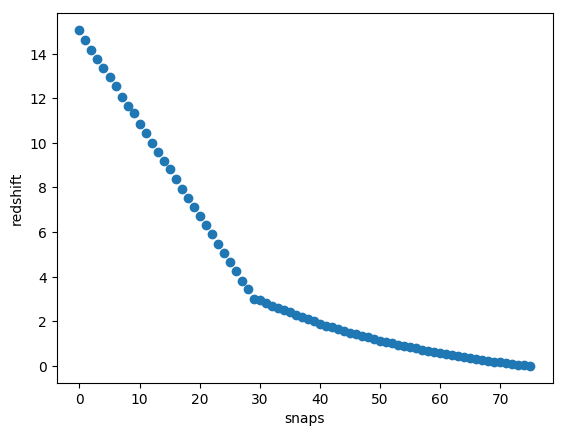

In [5]:
ax = zs['z'].plot(marker='o', linestyle='')
ax.set_xlabel('snaps')
ax.set_ylabel('redshift')

0it [00:00, ?it/s]/cosma/home/dp004/dc-oles1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
461it [00:01, 424.46it/s]
/cosma/home/dp004/dc-oles1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


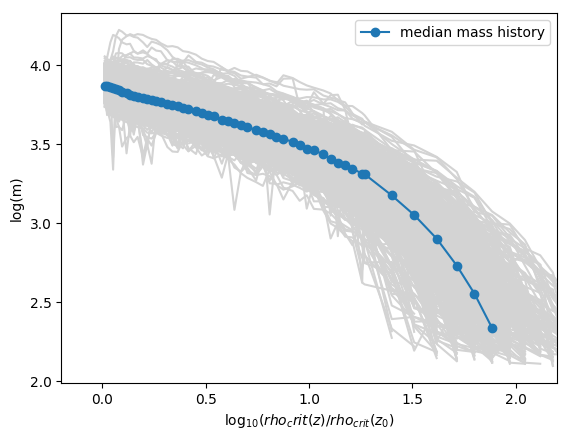

In [6]:
def plot_halo_mass_history(ax, ms):

    xs = zs.loc[ms.columns.values.astype(float).astype(int), 'log10_rho_c']

    for _, row in tqdm(ms.iterrows()):
        ax.plot(
            xs,
            np.log10(row),
            label='',
            color='lightgrey',
        )

    ax.plot(
        xs,
        np.log10(ms.median()),
        label='median mass history',
        color='C0',
        marker='o',
    )
    
    ax.legend()

fig, ax = plt.subplots(1)
# ax.set_title("%s, %.2f < $log_{10}(N_{part})$ < %.2f" %
#              (grav, bin_edges[bin], bin_edges[bin+1]))
ax.set_xlabel(r"$\log_{10}(rho_crit(z) / rho_{crit}(z_0)$")
ax.set_xlim((-0.2, 2.2))
# ax.set_ylim((-3.5, 0.5))
ax.set_ylabel("log(m)")

plot_halo_mass_history(
    ax,
    ms.loc[d[d["bin"] == bin].index]
)

# fig.savefig("./fig.pdf")